In [1]:
import os;import sys
import pandas as pd;import numpy as np;from itertools import combinations, permutations, product
from datetime import datetime;from datetime import date
from collections import Counter;import matplotlib ; from matplotlib import pyplot as plt
import networkx as nx; from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from scipy.io import loadmat
from scipy.sparse import csr_matrix
from scipy import stats
from sknetwork.clustering import Louvain, BiLouvain, modularity, bimodularity
import nbimporter ; import importlib as imp ; from scipy.optimize import minimize 
from scipy.optimize import LinearConstraint
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score
from sklearn.metrics import (confusion_matrix,  
                           accuracy_score) 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from random import gauss, random, choices
import pickle; import math
import geopandas as gpd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from scipy.stats.distributions import chi2


In [2]:
import statsmodels.api as sm 

In [3]:
path=os.getcwd()

In [4]:
def flatten(L):
    return [l for ll in L for l in ll]

In [5]:
def partition(l, nbin):
    dw = int(np.ceil(len(l)/nbin))
    ll = []
    i0 = 0
    while i0+dw<len(l):
        ll.append(l[i0:i0+dw])
        i0+=dw
    if i0 < len(l):
        ll[-1] = ll[-1]+l[i0:]
    return ll

In [40]:
def getSig(p):
    if p<0.005: return "***"
    elif p<0.01: return "**"
    elif p<0.05: return "*"
    else: return " "
    
def getSig_short(p):
    if p<0.005: return "*"
    else: return " "

<h2 style='text-align: center;'> Import Model Data </h2>

In [8]:
data = pd.read_csv('./../indicators/model_data_bonds_loans_d0_df.csv')

In [9]:
all_vars_ = ['FX_short', 
            'FX_long', 
             #'GDP Growth', 
            # 'GDP per cap', 
             #'Interest rate',
             'Ratings FC', 
             'Ratings LC',
             'Pol_Risk',
             'VIX', 
             'GDP Growth',
             #'market_volume_bonds',
             #'market_volume_loans', 
             'Amount', 
             #'LCY', 
             #'Domestic', 
             #'Bond', 
             'Tenor']

In [10]:
countries = ['India',
             'Mexico',
             'Brazil',
             'South Africa',
             'Indonesia',
             'Thailand',
             #'Malaysia',
             #'Turkey'
            ]

In [11]:
data = data[(data.Country.apply(lambda x: x in countries))
           &(data.Corporate==1)]

In [12]:
data['FCY']=data.LCY.apply(lambda x: 1 if x==0 else 0)

In [13]:
len(data)

1112

<h2 style='text-align: left;'> Statistics </h2>

In [14]:
df_stats = pd.DataFrame([data[all_vars_].mean().values,
                         data[all_vars_].std().values,
                        data[all_vars_].median().values,
                        data[all_vars_].min().values,
                        data[all_vars_].max().values],
            index=['Mean','SD','Median','Min','Max'], 
            columns = all_vars_).transpose()

In [15]:
df_stats

,Mean,SD,Median,Min,Max
FX_short,0.021850,0.011626,0.017240,0.003895,0.071517
FX_long,0.025543,0.010066,0.025145,0.005751,0.042143
Ratings FC,11.217626,1.473845,11.000000,9.000000,14.000000
Ratings LC,11.189748,1.497361,11.000000,9.000000,15.000000
Pol_Risk,-0.635474,0.288905,-0.688361,-1.442788,0.163664
VIX,18.787968,6.463640,17.260000,9.890000,35.540000
GDP Growth,3.219245,3.791808,3.000000,-8.600000,9.700000
Amount,0.160635,0.247782,0.065000,0.000100,2.000000
Tenor,10.797287,6.292321,10.000000,1.000000,40.000000


In [16]:
df_stats.to_csv('./../results/df_stats.csv')

In [17]:
### If predictor variables vary greatly across individuals but have little variation for each individual 
### then FE estimates will be imprecise and have large standard errors 

In [29]:
fig, ax = plt.subplots(1,1,figsize=(0.01,0.01));
ax.axis('off');

In [30]:
def plotResidualsPredicted(logit,X,y, ax = ax):
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    pred_true_vals_sorted = sorted(list(zip(logit.predict(X),y)),
                                   key=lambda x : x[0])
    residuals = [r[1]-r[0] for r in pred_true_vals_sorted]
    
    
    nbin = int(np.floor(np.sqrt(len(y)))) # suggested bin width is square-root of n_obs
    
    binned_x = partition([p[0] for p in pred_true_vals_sorted],nbin)
    binned_y = partition(residuals,nbin)
    
    x_av = [np.mean(x) for x in binned_x]
    y_av = [np.mean(y) for y in binned_y]
    
    conf_plus = [2*np.std(y)/np.sqrt(len(y)) for y in binned_y]
    conf_minus = [-2*np.std(y)/np.sqrt(len(y)) for y in binned_y]
    
    ##### plotting #####
    fs = 14
    ax.plot(x_av,conf_plus, color='red', linestyle='--', alpha = 0.8)
    ax.plot(x_av,conf_minus, color='red', linestyle='--',alpha = 0.8)
    
    for i,(x,y) in enumerate(list(zip(x_av,y_av))):
        if (y<conf_plus[i]) & (y>conf_minus[i]):
            ax.scatter(x, y, color='black')
        else:
            ax.scatter(x,y, color='red')
    
    ax.set_ylabel('Average residual', fontsize=fs)
    ax.set_xlabel('Average predicted probability', fontsize=fs)
    ax.tick_params(labelsize=fs)
    
    return binned_x, binned_y

In [31]:
def plotResidualsCovariate(logit,X,y,i,s,nrow = 1, ncol = 1, ax = ax, cat = False):
    
    pred_true_vals_sorted = sorted(list(zip(logit.predict(X),
                                            y,
                                            [x[i] for x in X])),key=lambda x : x[2])
    
    residuals = [r[1]-r[0] for r in pred_true_vals_sorted]
    
    if cat == False:
        nbin = int(np.floor(np.sqrt(len(y)))) # suggested bin width is square-root of n_obs
        binned_x = partition([p[2] for p in pred_true_vals_sorted],nbin)
        binned_y = partition(residuals,nbin)
        x_av = [np.mean(x) for x in binned_x]
        y_av = [np.mean(y) for y in binned_y]
        conf_plus = [2*np.std(y)/np.sqrt(len(y)) for y in binned_y]
        conf_minus = [-2*np.std(y)/np.sqrt(len(y)) for y in binned_y]
    
        
    else:
        cats = list(set([x[i] for x in X]))
        binned_x = [[x for pred_y,y,x in pred_true_vals_sorted if x == cat] 
                     for cat in cats]
        binned_y = [[pred_y-y for pred_y,y,x in pred_true_vals_sorted if x == cat] 
                     for cat in cats]
        x_av = [np.mean(b) for b in binned_x]
        y_av = [np.mean(b) for b in binned_y]
        conf_plus = [2*np.std(y)/np.sqrt(len(y)) for y in binned_y]
        conf_minus = [-2*np.std(y)/np.sqrt(len(y)) for y in binned_y]
    
    ##### plotting #####
    fs = 14
    ax.plot(x_av,conf_plus, color='red', linestyle='--', alpha = 0.8)
    ax.plot(x_av,conf_minus, color='red', linestyle='--',alpha = 0.8)
    
    for i,(x,y) in enumerate(list(zip(x_av,y_av))):
        if (y<conf_plus[i]) & (y>conf_minus[i]):
            ax.scatter(x, y, color='black')
        else:
            ax.scatter(x,y, color='red')
            
    ax.set_ylabel('Average residual', fontsize=fs)
    ax.set_xlabel('Average covariate', fontsize=fs)
    ax.set_title(s, fontsize=fs)
    ax.set_ylim(-0.3,0.3)
    ax.tick_params(labelsize=fs)
    
    return binned_x, binned_y

<h2 style='text-align: center;'> Results </h2>

In [42]:
mdl = data.copy();len(mdl)

1112

<h3 style='text-align: left;'> Pre-Processing </h2>

In [43]:
# Create a DataFrame with the one-hot encoded columns

# Drop first column to avoid the dummy variable trap
# ------ One-Hot Country encoding --------------- #
one_hot_df = pd.get_dummies(mdl.Country, drop_first=True)
mdl = pd.concat([mdl, one_hot_df], axis=1)
FE_country_ = ['India',
              'Mexico',
              'South Africa',
              'Indonesia',
              'Thailand',
              ]

# ------ One-Hot Tenor encoding --------------- #
one_hot_df = pd.get_dummies(mdl.Tenor_bracket, drop_first = True)
one_hot_df=one_hot_df.rename(columns = {'0-5 yrs':'tenor_1',
                    '5-10 yrs': 'tenor_2',
                    '>10 yrs': 'tenor_3',
                             } )
mdl = pd.concat([mdl, one_hot_df], axis=1)
FE_tenor_ = ['tenor_{}'.format(i) for i in [1,2,3]] 

#-------- TRANSFORM VARIABLES ------------#
mdl['Amount'] = mdl['Amount'].apply(lambda x: np.log(x))
mdl['WUI'] = mdl['WUI'].apply(lambda x: x/1000)

In [53]:
### Table for main
vars_cntrl_ = ['Amount','Domestic','Bond',
              'GDP Growth','Tenor']

vars_list_ = [
        ['FX_short','Ratings FC','Pol_Risk','VIX'] + vars_cntrl_ + FE_country_,
        ['FX_short','Pol_Risk','VIX'] + vars_cntrl_ + FE_country_,
        ]

all_vars_ = ['FX_short','Ratings FC','Pol_Risk','VIX'] + \
             vars_cntrl_

log_reg = {}
for i,vars_ in enumerate(vars_list_):
    log_reg[i] = \
     sm.Logit(mdl.FCY, mdl[vars_].to_numpy()).fit(maxiter=1000)
    
df_results = pd.DataFrame(
                columns=[i for i,v in enumerate(vars_list_)],
                index = all_vars_
                        )

for i, vars_ in enumerate(vars_list_):
    for j,v in enumerate(vars_):
        if v in all_vars_:
            df_results.loc[v][i] = '{:.2f}{}({:.2f})'.format(
                            log_reg[i].params[j],
                            getSig_short(log_reg[i].pvalues[j]),
                            #log_reg[i].pvalues[j],
                            log_reg[i].bse[j])

accuracy = []
for i,lr in log_reg.items():
    X_train, X_test, y_train, y_test = train_test_split(
                    mdl[vars_list_[i]],
                    mdl.FCY,test_size=0.33, random_state=20)

    y_prob = lr.predict(X_test)
    y_pred = [0 if p<0.5 else 1 for p in y_prob]

    # model accuracy versus guess major class
    accuracy.append(metrics.accuracy_score(y_test.values, y_pred))

#df_results.loc['Observations'] = [len(mdl)]*len(vars_list_)
df_results.loc['$R^2$'] = \
                ['{:.2f}'.format(log_reg[i].prsquared) 
                for i in log_reg.keys()]
"""df_results.loc['Log-likehood Ratio'] = \
                ['{:.2f}'.format(log_reg[i].llr )
                                   for i in log_reg.keys()]"""
df_results.loc['Accuracy'] = \
                ['{:.1f}'.format(100*a) for a in accuracy]

df_results=df_results.rename(columns={i:'Reg {}'.format(i+1)
                          for i in log_reg.keys()})

np.set_printoptions(linewidth=110)
df_results=df_results.rename(index = {'FX_short':'FX_RISK',
                          'Ratings FC':'SOV_RISK',
                          'Pol_Risk': 'POL_RISK',
                                     'Amount':'AMOUNT',
                                     'Domestic':'DOMESITC',
                                     'Bond':'BOND',
                                     'GDP Growth':'GDP_GROWTH',
                                     'Tenor':'TENOR'})
df_results.transpose()

Optimization terminated successfully.
         Current function value: 0.352281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362177
         Iterations 7


,FX_RISK,SOV_RISK,POL_RISK,VIX,AMOUNT,DOMESITC,BOND,GDP_GROWTH,TENOR,$R^2$,Accuracy
Reg 1,78.69*(12.54),0.33*(0.08),0.14 (0.41),0.04*(0.01),0.69*(0.07),-5.47*(0.69),-1.93*(0.25),0.03 (0.03),-0.09*(0.02),0.41,84.7
Reg 2,106.26*(11.43),NaN,0.44 (0.40),0.06*(0.01),0.66*(0.07),-4.08*(0.45),-1.66*(0.23),0.05 (0.03),-0.06*(0.02),0.40,84.2


In [64]:
sum(mdl.Bond==0),sum(mdl.Bond==1), sum(mdl.FCY==1)

(741, 371, 322)

In [45]:
df_results.transpose().to_csv('./../results/results_main.csv')

<h3 style='text-align: left;'> Binned Residuals</h3>

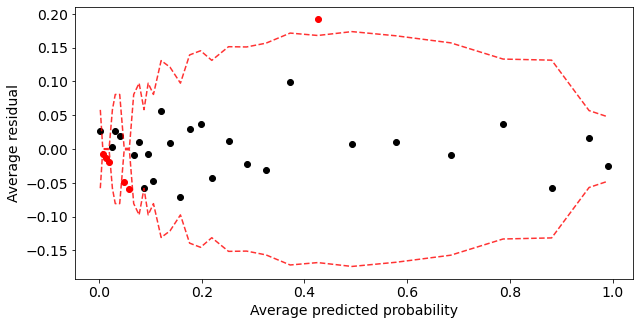

In [165]:
binned_x, binned_y = plotResidualsPredicted(
    log_reg[0],mdl[vars_list_[0]],mdl.FCY)

<h3 style='text-align: left;'> Likelihood Ratio </h2>

In [174]:
def LL(X,y,b):
    if len(X)!=len(y):
        print('X and y are not the same length.')
        return
    n = len(X)
    return sum([y.values[i]*np.dot(b,X[i])-
                np.log(1+np.exp(np.dot(b,X[i]))) for i in range(n)])

In [186]:
log_reg0 = sm.Logit(mdl.FCY, mdl[vars_].to_numpy()).fit(maxiter=1000)

In [200]:
-2*(log_reg0.llr-log_reg[0].llr)

347.01190191323076

In [194]:
log_reg0.llr

338.00085288105834

In [199]:
chi2.sf(-2*(log_reg0.llr-log_reg[0].llr), 1) # L2 has 1 DoF more than L1

1.89604291534501e-77

In [41]:
### Table for main
vars_cntrl_ = ['Amount','Domestic','Bond',
              'GDP Growth','Tenor']

log_reg0 = sm.Logit(mdl.FCY, mdl[vars_cntrl_+FE_country_].to_numpy()).fit(maxiter=1000)

vars_list_ = [
        ['FX_short'] + vars_cntrl_ + FE_country_,
        ['Ratings FC'] + vars_cntrl_ + FE_country_,
        ['Pol_Risk'] + vars_cntrl_ + FE_country_,
        ['VIX'] + vars_cntrl_ + FE_country_,
        ]

all_vars_ = ['FX_short','Ratings FC','Pol_Risk','VIX'] + \
             vars_cntrl_

log_reg = {}
for i,vars_ in enumerate(vars_list_):
    log_reg[i] = \
     sm.Logit(mdl.FCY, mdl[vars_].to_numpy()).fit(maxiter=1000)
    
df_results = pd.DataFrame(
                columns=[i for i,v in enumerate(vars_list_)],
                index = all_vars_
                        )

for i, vars_ in enumerate(vars_list_):
    for j,v in enumerate(vars_):
        if v in all_vars_:
            df_results.loc[v][i] = '{:.2f}{}({:.2f})'.format(
                            log_reg[i].params[j],
                            getSig_short(log_reg[i].pvalues[j]),
                            #log_reg[i].pvalues[j],
                            log_reg[i].bse[j])

accuracy = []
for i,lr in log_reg.items():
    X_train, X_test, y_train, y_test = train_test_split(
                    mdl[vars_list_[i]],
                    mdl.FCY,test_size=0.33, random_state=20)

    y_prob = lr.predict(X_test)
    y_pred = [0 if p<0.5 else 1 for p in y_prob]

    # model accuracy versus guess major class
    accuracy.append(metrics.accuracy_score(y_test.values, y_pred))

df_results.loc['Observations'] = [len(mdl)]*len(vars_list_)
df_results.loc['McFaddens R-squared'] = \
                ['{:.2f}'.format(log_reg[i].prsquared) 
                for i in log_reg.keys()]

# LLR
p = [chi2.sf(-2*(log_reg0.llr-log_reg[i].llr), 1) for i in log_reg.keys()]
df_results.loc['Log-likehood Ratio'] = \
                ['{:.2f}'.format(log_reg[i].llr )
                                   for i in log_reg.keys()]
df_results.loc['Accuracy'] = \
                ['{:.1f}'.format(100*a) for a in accuracy]

df_results=df_results.rename(columns={i:'Reg {}'.format(i+1)
                          for i in log_reg.keys()})

np.set_printoptions(linewidth=110)
df_results=df_results.rename(index= {'FX_short':'FX_RISK',
                           'Ratings FC': 'SOV_RISK',
                           'Pol_Risk':'POL_RISK',
                           'Amount':'AMOUNT',
                           'Domestic':'DOMESTIC',
                           'Bond':'BOND',
                           'GDP Growth': 'GDP_GROWTH',
                           'Tenor':'TENOR'})
#df_results.transpose()
df_results

Optimization terminated successfully.
         Current function value: 0.449786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417052
         Iterations 7


,Reg 1,Reg 2,Reg 3,Reg 4
FX_RISK,110.86*(10.37),NaN,NaN,NaN
SOV_RISK,NaN,0.59*(0.06),NaN,NaN
POL_RISK,NaN,NaN,-1.34*(0.35),NaN
VIX,NaN,NaN,NaN,0.09*(0.01)
AMOUNT,0.67*(0.07),0.64*(0.07),0.53*(0.06),0.53*(0.06)
DOMESTIC,-3.36*(0.38),-4.57*(0.52),-1.71*(0.28),-2.46*(0.31)
BOND,-1.46*(0.22),-1.84*(0.24),-0.59*(0.17),-1.08*(0.20)
GDP_GROWTH,0.04 (0.03),-0.01 (0.02),0.01 (0.02),0.04 (0.02)
TENOR,-0.05*(0.02),-0.10*(0.02),-0.00 (0.01),-0.02 (0.01)
Observations,1112,1112,1112,1112


In [212]:
df_results.to_csv('./../results/Table_S3.csv')

<h3 style='text-align: left;'> AUC</h3>

In [167]:
X_train, X_test, y_train, y_test = train_test_split(
                    mdl[vars_list_[0]],
                    mdl.FCY,test_size=0.33, random_state=20)

In [168]:
y_prob = log_reg[0].predict(X_test)

In [169]:
Counter(y_test)

Counter({0: 260, 1: 107})

In [170]:
y_pred = [0 if p<0.5 else 1 for p in y_prob]

In [171]:
# model accuracy versus guess major class
metrics.accuracy_score(y_test.values, y_pred),\
metrics.accuracy_score(y_test.values, [0]*len(y_test))

(0.8474114441416893, 0.7084468664850136)

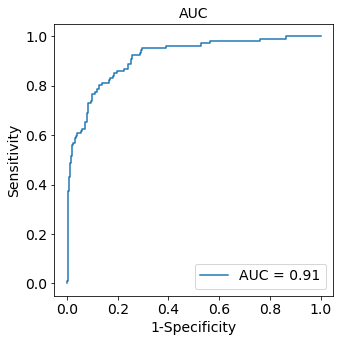

In [172]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
fs=14
auc = metrics.roc_auc_score(y_test, y_prob)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_prob)
ax.plot(fpr,tpr,label='AUC = {:.2f}'.format(auc))
ax.tick_params(labelsize=fs)
ax.legend(loc=4, fontsize=fs)
ax.set_title('AUC', fontsize=fs);
ax.set_ylabel('Sensitivity', fontsize=fs);
ax.set_xlabel('1-Specificity', fontsize=fs);

<h3 style='text-align: left;'> Country by country accuracy</h3>

In [173]:
for c in countries:
    X_test, y_test = mdl[mdl.Country==c][vars_list_[0]],\
                     mdl[mdl.Country==c].FCY
    y_prob = log_reg[0].predict(X_test)
    y_pred = [0 if p<0.5 else 1 for p in y_prob]
    y_guess = [Counter(y_test).most_common()[0][0]]*len(y_test)
    print(c,
          '{:.2f}'.format(
              metrics.accuracy_score(y_test.values, y_pred)),
        '{:.2f}'.format(
              metrics.accuracy_score(y_test.values, y_guess)))

India 0.82 0.75
Mexico 0.81 0.52
Brazil 0.87 0.78
South Africa 0.90 0.78
Indonesia 0.77 0.69
Thailand 0.85 0.81
